### Osceola JFSP initial output and analysis
-Daymet climate <p>
-Raws station fire weather (clipped to severe events for 'extreme') <p>
-Managment implementations (Swamp buffer thinning)

#### Load required packages and utilities

In [128]:
# Notebook magics
%matplotlib inline

# Dependencies and helper functions
from NECN_utils import *
import os, glob
from IPython.display import Image

# Data directory
dataDir = 'Y:/DanK/Osceola/SimulationOutput/'

#### Create a quick list of the directories that hold simulation data
These are fully qualified folder locations

In [129]:
noManagement = []
for sim in glob.glob(dataDir + '*_Noman*'):
    noManagement.append(sim)

#### Make use of the LANDIS NECN utilities script
cenOutputGen and genCentWeightedMeansDF are the meat and potatoes of the code that turns a bunch of replicate simulations into an assortment of dataframes that can be used to ask questions about the collection of model results.

In [130]:
nomanContemp, nomanContemp_m = centOutputGen(dataDir, noManagement[0].split('\\')[1])
nomanExtreme, nomanExtreme_m = centOutputGen(dataDir, noManagement[1].split('\\')[1])

nomanC_w, nomanC_sims, nomanC_summed = genCentWeightedMeansDF(nomanContemp, 'nomanC')
nomanE_w, nomanE_sims, nomanE_summed = genCentWeightedMeansDF(nomanExtreme, 'nomanE')

totSimsNoMan = pd.concat([nomanC_w, nomanE_w])
totSimsAllNoMan =  pd.concat([nomanC_sims, nomanE_sims])

totSimsAllNoMan['Trtmnt'] = 'No Management'
totSimsAllNoMan['FW']     = 'Contemporary'
totSimsAllNoMan.FW[totSimsAllNoMan.Sim == 'nomanE'] = 'Extreme'

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Carbon accumulation results

#### Plot the max, mean, 5th percentile, and minimum of AGC
across the collection of simulation replicates. 

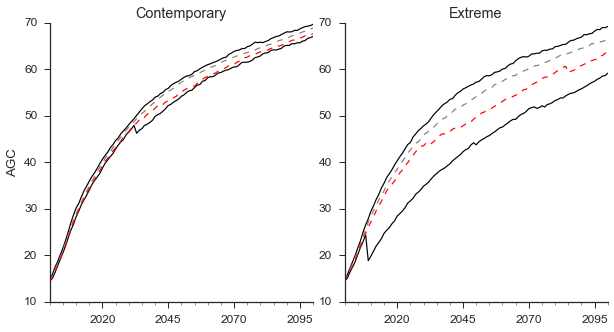

In [131]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)
f, (ax1, ax2) = plt.subplots(1,2, figsize =(10,5))
plt.subplots_adjust(wspace = 0.12)

plotAllSimsMinMaxMed(totSimsAllNoMan[totSimsAllNoMan.Sim == 'nomanC'], 
                     'AGBw', 'No Management', ax = ax1)
plotAllSimsMinMaxMed(totSimsAllNoMan[totSimsAllNoMan.Sim == 'nomanE'], 
                     'AGBw', 'No Management', ax = ax2)

ax1.set_ylabel('AGC')
ax1.set_title('Contemporary')
ax2.set_title('Extreme')

sns.despine()

### Wildfire results

#### Generate the wildfire severity maps
This includes mean and variance rasters

In [133]:
sevmaps_mu = []
sevmaps_var = []

for sim in noManagement:
    print sim
    
    sevrasters = severityStack(sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevmaps_mu.append(sevmap)
    sevmaps_var.append(sevVarmap)

Y:/DanK/Osceola/SimulationOutput\Osceola_Noman_Contemporary
Y:/DanK/Osceola/SimulationOutput\Osceola_Noman_Extreme


#### Plot the mean wildfire severity maps for the Osceola

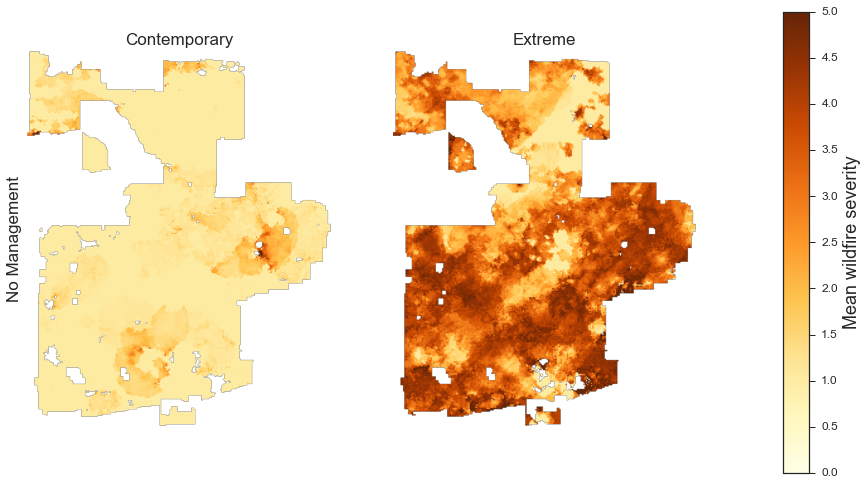

In [134]:
f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,20))
#plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevmaps_mu[0][noManagement[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax2.imshow(sevmaps_mu[1][noManagement[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('No Management', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.03, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)

#### Plot the variance of wildfire severity maps for the Osceola

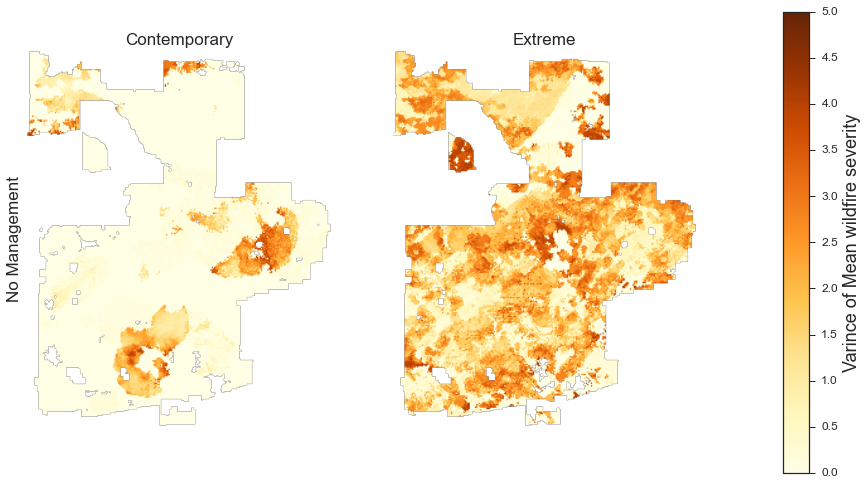

In [135]:
f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,20))
#plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevmaps_var[0][noManagement[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax2.imshow(sevmaps_var[1][noManagement[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('No Management', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.03, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Varince of Mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)

#### Dig into the fire logs
and create plots of cumulative area burned, total area burned, and maybe use the ecoregion raster and the mean severity rasters to ask questions about the distribution of fire across the landscape. I don't have any functions written to handle this quickly, so I'll define them here and move them into the utils script later on.

In [136]:
DFFSlog = 'dynamic-fire-test-log.csv'
idx = 0

for sim in noManagement:
    repnames = next(os.walk(sim))[1]
    num_replicates = len(repnames)
    for rep in repnames:
        repnum = rep.split('replicate')[1]
        
        if idx == 0:
            flog = pd.read_csv(sim + '/' 'replicate' + \
                               repnum + '/' + DFFSlog)
            flog['rep'] = repnum
            flog['sim'] = sim.split('\\')[1]
            idx += 1
        else:
            nextflog = pd.read_csv(sim + '/' 'replicate' + \
                                   repnum + '/' + DFFSlog)
            nextflog['rep'] = repnum
            nextflog['sim'] = sim.split('\\')[1]
            flog = pd.concat([flog,  nextflog])
            idx += 1

### In the Osceola simulation environment, each pixel is 150 x 150 m
That means each pixel is 2.25 ha. So, most of the calculations are scaling square meters to ha, and the pixel reference is implicitly handled by the model (as is the case in the Century calculations). However, the fire logs refer to total Sites in the event, which to me means number of pixels. That means we need to calculate the area of the total sites by 2.25 to get to ha correctly.

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


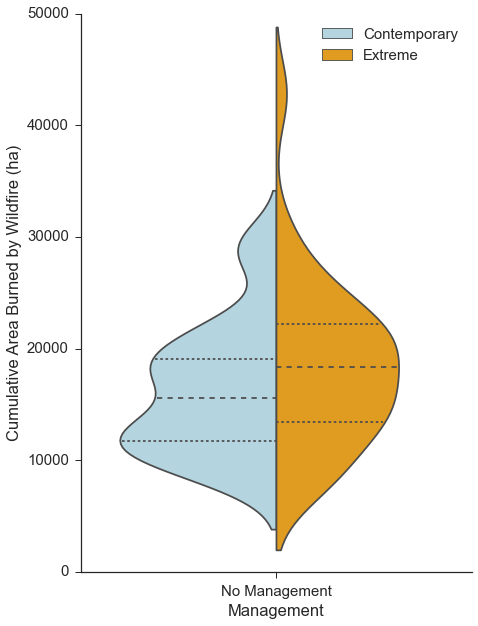

In [137]:
sumFiresByRep = flog.groupby(['rep', 'sim']).sum().reset_index()
sumFiresByRep['Management'] = 'No Management'
sumFiresByRep['FW'] = 'Contemporary'
sumFiresByRep.FW[sumFiresByRep.sim == 'Osceola_Noman_Extreme'] = 'Extreme'

sumFiresByRep['AreaInHa'] = sumFiresByRep.TotalSitesInEvent * 2.25
sns.set_context('notebook', font_scale=1.5)
f, (ax1) = plt.subplots(1,1, figsize =(7,10))

sns.violinplot(y = 'AreaInHa', x = 'Management', 
               hue = 'FW', inner = 'quartile',
               palette = ['lightblue','orange'],
               data = sumFiresByRep, split = True, bw=.4,
               ax = ax1)
ax1.legend(loc = 1)
ax1.set_ylabel('Cumulative Area Burned by Wildfire (ha)')
sns.despine()

### Wildfire emissions as  function of management
One of the targets for this research is to determine the quantity of C emitted as a function of wildfire, and prescribed fire (Rx fire). LANDIS-II DFFS handles wildfire X efflux as a native output in the Century NECN extension. However, the Rx fire C emissions are less straight forward, and parsing where those emissions come from is again not very simple. 

The goal here is to produce a total C lost curve, which will include wildfire C efflux and treatment (Rx + thinning) C efflux. Along the way we will group the data apropriately to produce box and bar plots that characterize each component of total C efflux separately.